In [1]:
from skimage.io import imread
from skimage.transform import resize
from sklearn.ensemble import RandomForestClassifier as RF
import glob
import os
from sklearn import cross_validation
from sklearn.cross_validation import StratifiedKFold as KFold
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
from matplotlib import colors
from pylab import cm
import numpy as np
import pandas as pd

from sklearn import decomposition
from sklearn.decomposition import RandomizedPCA
from sklearn import svm
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC
from time import time
#from multiprocessing import Pool
#pool = Pool(processes = 6)

from sklearn.linear_model import SGDClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from operator import itemgetter
from scipy.stats import randint as sp_randint
from sklearn.feature_extraction import image

from sklearn.feature_extraction.image import PatchExtractor
from sklearn.cluster import KMeans, MiniBatchKMeans
import pickle

In [2]:
import numpy as np
from scipy import linalg
from sklearn.utils import array2d, as_float_array
from sklearn.base import TransformerMixin, BaseEstimator
 
 
class ZCA(BaseEstimator, TransformerMixin):
 
    def __init__(self, regularization=10**-5, copy=False):
        self.regularization = regularization
        self.copy = copy
 
    def fit(self, X, y=None):
        X = array2d(X)
        X = as_float_array(X, copy = self.copy)
        self.mean_ = np.mean(X, axis=0)
        X -= self.mean_
        sigma = np.dot(X.T,X) / X.shape[1]
        U, S, V = linalg.svd(sigma)
        tmp = np.dot(U, np.diag(1/np.sqrt(S+self.regularization)))
        self.components_ = np.dot(tmp, U.T)
        return self
 
    def transform(self, X):
        X = array2d(X)
        X_transformed = X - self.mean_
        X_transformed = np.dot(X_transformed, self.components_.T)
        return X_transformed

In [2]:
2+2

4

In [3]:
# Scoring function for kaggle competition
def multiclass_log_loss(y_true, y_pred, eps=1e-15):
    predictions = np.clip(y_pred, eps, 1 - eps)

    # normalize row sums to 1
    predictions /= predictions.sum(axis=1)[:, np.newaxis]

    actual = np.zeros(y_pred.shape)
    n_samples = actual.shape[0]
    actual[np.arange(n_samples), y_true.astype(int)] = 1
    vectsum = np.sum(actual * np.log(predictions))
    loss = -1.0 / n_samples * vectsum
    return loss

# Utility function to report best scores
def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")
        
 
def print_scoring(y_pred):
    y_class = np.array([list(x).index(max(x)) for x in y_pred])
    print "classifier final score:    ", multiclass_log_loss(y_test, y_pred)
    print "f1-score: %.3f   accuracy: %.3f   precision: %.3f   recall: %.3f" % (metrics.f1_score(y_test, y_class), 
        metrics.accuracy_score(y_test, y_class), metrics.precision_score(y_test, y_class), metrics.recall_score(y_test, y_class))
    print metrics.classification_report(y_test, y_class)
    
        
multiclass_log_loss_func = metrics.make_scorer(score_func = multiclass_log_loss, greater_is_better=False, needs_proba=True)

In [4]:
data_dir = '/home/ubuntu/kaggle/plankton/data'

train_dir = os.path.join(data_dir, 'train')
train_dirs = list(set(glob.glob(os.path.join(train_dir, '*'))))
train_paths_by_type = {os.path.basename(path): list(set(glob.glob(os.path.join(path, '*')))) for path in train_dirs}

test_dir = os.path.join(data_dir, 'test')
test_paths = list(set(glob.glob(os.path.join(test_dir, '*'))))
test_files = [os.path.basename(p) for p in test_paths]

img_dims = (25,25)
img_width, img_height = img_dims
imageSize = img_height*img_width


patches_per_image = 5
loaded_img_dims = (28,28)
loaded_img_width, loaded_img_height = loaded_img_dims
loaded_imageSize = loaded_img_width * loaded_img_height

num_train_rows = sum([len(n) for n in train_paths_by_type.values()]) * patches_per_image
num_test_rows = len(test_paths)

plankton_types = []
train_files = []
test_files = []



In [5]:
%store -r X
%store -r y
%store -r X_submission
%store -r X_submission_images
%store -r X_images

In [6]:
def load_training_images():
    print "loading and resizing the training images"
    patchesExtractor = PatchExtractor(patch_size=img_dims, max_patches=patches_per_image, random_state=0)
    
    t0 = time()
    file_index, type_index = 0, 0
    for plankton_type in train_paths_by_type:
        files_for_type = train_paths_by_type[plankton_type]
        for f in files_for_type:
            img = imread(f, as_grey=True)
            X_images.append(img)
            img_resized = resize(img, loaded_img_dims)
            train_files.append(f)
            patches = patchesExtractor.transform(img_resized.reshape(1,loaded_img_height, loaded_img_width))
            patches = patches.reshape((patches.shape[0], imageSize))
            
            for patch in patches:
                X[file_index, 0:imageSize] = np.reshape(patch, (1, imageSize))
                y[file_index] = type_index
                file_index += 1
    
                report = [int((j+1)/5. * num_train_rows) for j in range(5)]
                if file_index in report: print np.ceil(file_index * 100.0 / num_train_rows), "% done"
        type_index += 1
    print "completed reading training images in %.2f seconds" % (time()-t0)

def load_submission_images():
    print "loading and resizing submission images"
    t0 = time()
    file_index = 0
    for f in test_paths:
        img = imread(f, as_grey=True)
        X_submission_images.append(img)
        img_resized = resize(img, img_dims)
        X_submission[file_index, 0:imageSize] = np.reshape(img_resized, (1, imageSize))
        file_index += 1
    
        report = [int((j+1)/20. * num_test_rows) for j in range(20)]
        if file_index in report: print np.ceil(file_index * 100.0 / num_test_rows), "% done"
    print "completed reading submission images in %.2f seconds" % (time()-t0)
    


if 'X_images' in globals():
    print 'training variables already loaded into memory! dont need to read image files.'
else:
    X = np.zeros((num_train_rows, imageSize), dtype=float)
    y = np.zeros(num_train_rows)
    X_images = []
    load_training_images()
    print "training images loaded! X, y are the training images, and X_submission is the test images"
    %store X
    %store y
    %store X_images
    
if 'X_submission_images' in globals():
    print "Submission variables already loaded into memory!"
else:
    X_submission = np.zeros((num_test_rows, imageSize), dtype=float)
    X_submission_images = []
    load_submission_images()
    print "submission images loaded! X, y are the training images, and X_submission is the test images"
    %store X_submission
    %store X_submission_images  

training variables already loaded into memory! dont need to read image files.
Submission variables already loaded into memory!


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# Creating the patch k-means thing

In [8]:
num_centers = 200
%store -r k100means
if 'k100means' in globals():
    print 'k100means loaded from memory'
else:
    patchesExtractor = PatchExtractor(patch_size=(8,8), max_patches=80, random_state=0)
    patches = patchesExtractor.transform(X_train.reshape((X_train.shape[0],img_height,img_width)))
    patches = patches.reshape((patches.shape[0], 64))

    t0 = time()
    k100means = MiniBatchKMeans(n_clusters=num_centers, init_size=num_centers)
    k100means.fit(patches)
    del patches
    %store k100means
    print "fit k-means to patches in %.2f seconds" % (time() - t0)

k100means loaded from memory


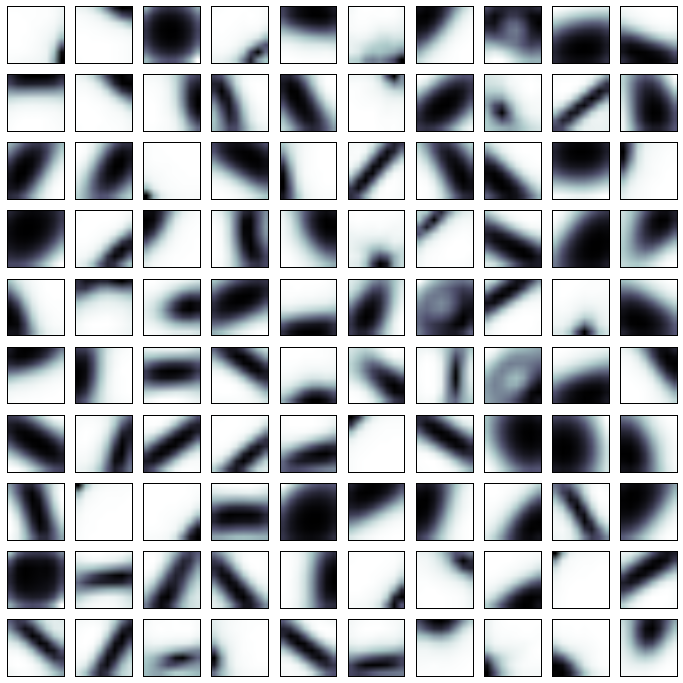

In [9]:
fig = plt.figure(figsize=(12,12))
for i in range(100):
    ax = fig.add_subplot(10,10, i+1, xticks=[], yticks=[])
    im = k100means.cluster_centers_[i].reshape((8,8))
    ax.imshow(im, cmap=plt.cm.bone)

In [10]:
patch_dims = (8,8)
patch_size = 64
num_patches = image.extract_patches_2d(np.ones((25,25)), (8,8)).shape[0]

def getSubMatrices(M, x_num, y_num):
    y_width, x_width = M.shape[0]/y_num, M.shape[1]/x_num
    new_M = np.zeros_like(M).reshape(x_num*y_num, M.shape[0]*M.shape[1]/(x_num*y_num), M.shape[2])
    #print "new_M shape: ", new_M.shape
    for y in range(y_num):
        for x in range(x_num):
            #print "x=", x, "y=", y, "idx=", x+y*x_num
            #print M[y*y_width:(y+1)*y_width,x*x_width:(x+1)*x_width]
            new_M[x + y*x_num,:,:] = M[y*y_width:(y+1)*y_width,x*x_width:(x+1)*x_width,:].reshape(x_width*y_width,M.shape[2])
    return new_M

def transform_img_with_kmeans(orig_img):
    img = orig_img
    if len(img.shape) == 1:
        img = img.reshape(img_dims)
    img_patches = image.extract_patches_2d(img, patch_dims)
    img_patches_flat = img_patches.reshape((img_patches.shape[0], patch_size))
    centers = k100means.transform(img_patches_flat)
    centers = centers.reshape(sqrt(num_patches), sqrt(num_patches), num_centers)
    centers_segmented = getSubMatrices(centers, 2, 2)
    centers_avg = centers_segmented.mean(axis=1).reshape((4*num_centers))
    return centers_avg
    #centers_avg = centers.reshape((4, num_patches/4, num_centers)).mean(axis=2).reshape((X_train.shape[0],4*num_centers))

def transform_images_to_kmeans_domain(images):
    return np.array([transform_img_with_kmeans(img) for img in images])

%store -r centers_train
%store -r centers_test

if 'centers_train' in globals():
    print "centers_train loaded from memory"
else:
    print "time:", datetime.datetime.now()
    t0 = time()
    centers_train = transform_images_to_kmeans_domain(X_train)
    print "centers_train loaded!"
    %store centers_train
    
    centers_test = transform_images_to_kmeans_domain(X_test)
    print "centers test loaded!"
    %store centers_test
    
    print "completed in %.2f seconds" % (time() - t0)


no stored variable centers_train
no stored variable centers_test
time: 2015-02-23 01:33:44.218802
centers_train loaded!
Stored 'centers_train' (ndarray)
centers test loaded!
Stored 'centers_test' (ndarray)
completed in 287.91 seconds


num patches (per image) = 324


# Doing classification now:

In [11]:
print "starting param sweep"
print "time:", datetime.datetime.now()
t0 = time()
pipe = Pipeline(steps=[('pca', RandomizedPCA()), ('svm', svm.SVC())])

param_dist = dict(pca__n_components=[150,200,250,300],
                  pca__whiten=[True, False],
                  pca__random_state=[0],
                  svm__C=[1.0, 6.0],
                  svm__kernel=["rbf"])
#print "doing a fit"
#pipe.set_params(**grid_search.best_params_)
#pipe.set_params(svm__probability= True)
#pipe.fit(centers_train, y_train)
#y_pred = pipe.predict_proba(centers_test)
#print "finished fit"

#print_scoring(y_pred)
#grid_search = RandomizedSearchCV(pipe, param_distributions=param_dist, n_jobs=8, n_iter=48)
grid_search = GridSearchCV(pipe, param_grid=param_dist, n_jobs=15, refit=False, verbose=1)

grid_search.fit(centers_train, y_train)
print "completed in %.2f seconds" % (time() - t0)
report(grid_search.grid_scores_, 28)

#print "doing a fit"
#pipe.set_params(**grid_search.best_params_)
#pipe.set_params(svm__probability= True)
#pipe.fit(centers_train, y_train)
#y_pred = pipe.predict_proba(centers_test)
#print "finished fit"

#print_scoring(y_pred)

starting param sweep
time: 2015-02-23 01:38:32.147582
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=15)]: Done   1 jobs       | elapsed: 103.5min
[Parallel(n_jobs=15)]: Done  10 out of  12 | elapsed: 160.0min remaining: 32.0min
[Parallel(n_jobs=15)]: Done  12 out of  12 | elapsed: 160.0min finished


completed in 9599.12 seconds
Model with rank: 1
Mean validation score: 0.666 (std: 0.002)
Parameters: {'pca__n_components': 300, 'svm__C': 6.0, 'pca__random_state': 0, 'svm__kernel': 'rbf', 'pca__whiten': True}

Model with rank: 2
Mean validation score: 0.663 (std: 0.001)
Parameters: {'pca__n_components': 250, 'svm__C': 6.0, 'pca__random_state': 0, 'svm__kernel': 'rbf', 'pca__whiten': True}

Model with rank: 3
Mean validation score: 0.659 (std: 0.002)
Parameters: {'pca__n_components': 200, 'svm__C': 6.0, 'pca__random_state': 0, 'svm__kernel': 'rbf', 'pca__whiten': True}

Model with rank: 4
Mean validation score: 0.652 (std: 0.003)
Parameters: {'pca__n_components': 150, 'svm__C': 6.0, 'pca__random_state': 0, 'svm__kernel': 'rbf', 'pca__whiten': True}



In [ ]:
report(grid_search.grid_scores_, 28)

In [32]:
print "doing a fit"
pipe.set_params(**grid_search.best_params_)
pipe.set_params(svm__probability= True)
pipe.fit(centers_train, y_train)
y_pred = pipe.predict_proba(centers_test)
print "finished fit"

print_scoring(y_pred)
report(grid_search.grid_scores_, 28)

doing a fit
finished fit
classifier final score:     1.66118376178
f1-score: 0.568   accuracy: 0.580   precision: 0.576   recall: 0.580
             precision    recall  f1-score   support

        0.0       0.73      0.78      0.75       136
        1.0       0.39      0.19      0.25        70
        2.0       1.00      0.33      0.50        12
        3.0       0.23      0.13      0.17        38
        4.0       0.00      0.00      0.00        17
        5.0       0.21      0.12      0.15        25
        6.0       0.45      0.41      0.43        44
        7.0       0.47      0.51      0.49       216
        8.0       0.34      0.32      0.33       147
        9.0       0.69      0.72      0.71       315
       10.0       0.49      0.45      0.47       190
       11.0       0.30      0.19      0.23        16
       12.0       0.80      0.35      0.48        23
       13.0       0.00      0.00      0.00         6
       14.0       0.62      0.26      0.37        19
       15.0    

/home/ubuntu/anaconda/lib/python2.7/site-packages/sklearn/metrics/metrics.py:1771: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda/lib/python2.7/site-packages/sklearn/metrics/metrics.py:1771: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda/lib/python2.7/site-packages/sklearn/metrics/metrics.py:1771: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [23]:
#Mean validation score: 0.549 (std: 0.002)
#Parameters: {'pca__n_components': 100, 'svm__C': 6.0, 'pca__random_state': 0, 'svm__kernel': 'rbf', 'pca__whiten': True}

centers_submission = transform_images_to_kmeans_domain(X_submission)

print "starting training"
print "time:", datetime.datetime.now()
t0 = time()
pipe = Pipeline(steps=[('pca', RandomizedPCA(n_components = 300, whiten=True)), ('svm', svm.SVC(C=6.0, kernel='rbf', probability=True))])

pipe.fit(centers_train, y_train)
print "completed in %.2f seconds" % (time() - t0)


print "doing the prediction"
t0 = time()
y_submission = pipe.predict_proba(centers_submission)
print "finished predict in %.2f seconds" % (time() - t0)

print "generating submission"
submission_filenames = np.array([os.path.basename(x) for x in test_paths])
df = pd.DataFrame(y_submission, columns=train_paths_by_type.keys(), index=submission_filenames)
df.index.name = 'image'
header = sort(train_paths_by_type.keys())
df = df[header]
df.to_csv('fifth_submission.csv')

starting training
time: 2015-02-01 02:05:46.103629
completed in 439.17 seconds
doing the prediction
finished predict in 817.30 seconds


# Generating the submission

In [25]:
submission_filenames = np.array([os.path.basename(x) for x in test_paths])
df = pd.DataFrame(y_submission, columns=train_paths_by_type.keys(), index=submission_filenames)
df.index.name = 'image'
header = sort(train_paths_by_type.keys())
df = df[header]
df.to_csv('fifth_submission.csv')

In [26]:
!gzip fifth_submission.csv

In [27]:
!ls *.gz

fifth_submission.csv.gz


In [12]:
%pwd

u'/home/ubuntu/kaggle/plankton'

In [13]:
%ls

data/                            patches.ipynb
elm.py                           patches.ipynbV6h5nS
elm.pyc                          random_layer.py
fifth_submission.csv.gz          random_layer.pyc
first_plankton_classifier.ipynb  second_plankton_copy.ipynb
param_sweep.ipynb                second_plankton.ipynb
patches2.ipynb


In [38]:
!s3cmd put patches2.ipynb s3://bellar/ML/kaggle/plankton/patches2.ipynb

patches2.ipynb -> s3://bellar/ML/kaggle/plankton/patches2.ipynb  [1 of 1]
 419896 of 419896   100% in    0s     5.66 MB/s  done


                       DIR   s3://bellar/ML/kaggle/plankton/
2015-02-23 04:40    419896   s3://bellar/ML/kaggle/plankton
